DCGAN Implementation in PyTorch. This is also the baseline for any kind of experiments to be performed

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Use the FID Score implementation from https://github.com/mseitzer/pytorch-fid

In [0]:
!git clone https://github.com/mseitzer/pytorch-fid.git

Cloning into 'pytorch-fid'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Unpacking objects: 100% (49/49), done.


In [0]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from IPython.display import clear_output
from torch.utils.data import DataLoader
from torch.autograd import grad
from torchvision.datasets import MNIST, FashionMNIST, KMNIST
from torchvision import transforms
from tqdm import tqdm

## Dataset loading and displaying images

In [0]:
%matplotlib inline

In [0]:
# define some transforms
T = transforms.Compose([
    transforms.ToTensor()
])
# get the mnist dataset
root = 'mnist/'
mnist_dataset = MNIST(root, download=True, transform=T)
fashion_mnist_dataset = FashionMNIST(root, download=True, transform=T)
kmnist_dataset = KMNIST(root, download=True, transform=T)
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
fashion_mnist_loader = DataLoader(fashion_mnist_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)
kmnist_loader = DataLoader(kmnist_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 22174673.10it/s]                            


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


32768it [00:00, 311355.72it/s]                           
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


1654784it [00:00, 5293281.50it/s]                           
8192it [00:00, 128143.43it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw
Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...


0it [00:00, ?it/s]

Done!


26427392it [00:01, 13994683.90it/s]                             


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 95521.66it/s]                            
0it [00:00, ?it/s]

Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw


4423680it [00:01, 4052545.35it/s]                             
0it [00:00, ?it/s]

Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw


8192it [00:00, 30470.73it/s]            
0it [00:00, ?it/s]

Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw
Processing...
Done!


18169856it [00:02, 6422523.35it/s]                              


Extracting mnist/KMNIST/raw/train-images-idx3-ubyte.gz to mnist/KMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 86596.83it/s]                            
0it [00:00, ?it/s]

Extracting mnist/KMNIST/raw/train-labels-idx1-ubyte.gz to mnist/KMNIST/raw


3047424it [00:01, 1854718.30it/s]                             
0it [00:00, ?it/s]

Extracting mnist/KMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/KMNIST/raw


8192it [00:00, 31774.65it/s]            

Extracting mnist/KMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/KMNIST/raw
Processing...
Done!


In [0]:
def display_grid(batch, num_rows=8):
    assert isinstance(batch, torch.Tensor)
    batch_size = batch.shape[0]
    num_cols = int(batch_size / num_rows)
    if batch.device.type == 'cuda':
        batch_np = batch.cpu().numpy()
    else:
        batch_np = batch.numpy()

    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 8))
    img_idx = 0
    for i in range(num_rows):
        for j in range(num_cols):
            img = batch_np[img_idx]
            if img.shape[0] == 3:
                img = np.reshape(img, (img.shape[1], img.shape[2], img.shape[0]))
            else:
                img = np.reshape(img, (img.shape[1], img.shape[2]))
            ax[i, j].imshow(img)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            img_idx = img_idx + 1
    plt.show()


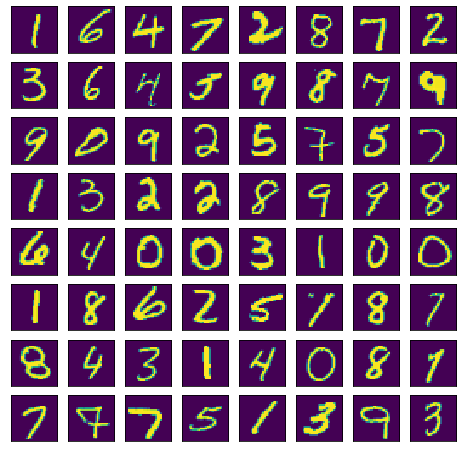

In [0]:
# visualize some sample images
sample_images, _ = next(iter(mnist_loader))
display_grid(sample_images, num_rows=8)

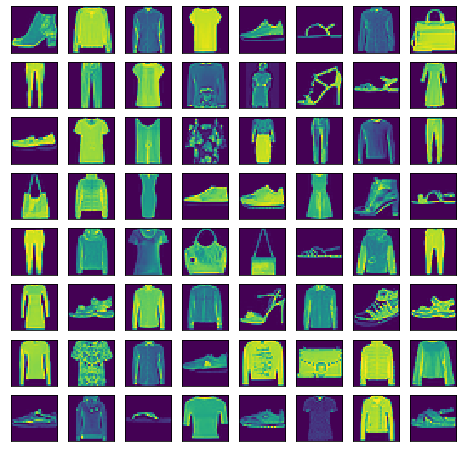

In [0]:
sample_fashion_images, _ = next(iter(fashion_mnist_loader))
display_grid(sample_fashion_images, num_rows=8)

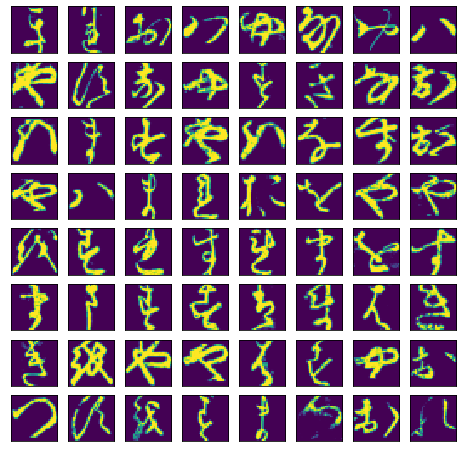

In [0]:
sample_jap_images, _ = next(iter(kmnist_loader))
display_grid(sample_jap_images, num_rows=8)

## Defining the GAN architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# Define the random state
random_state = 2019
torch.random.manual_seed(random_state)

In [0]:
def swish(x):
    return x * torch.sigmoid(x)

def mish(x):
    return x * torch.tanh(F.softplus(x))

In [0]:
class Generator(nn.Module):
    
    def __init__(self, code_size, training=False):
        super(Generator, self).__init__()
        self.training = training
        self.code_size = code_size
        
        # Define the model here
        self.deconv_1 = nn.ConvTranspose2d(code_size, 256, 4, stride=2, bias=False)
        torch.nn.init.normal_(self.deconv_1.weight, std=0.02)
        self.bn_1 = nn.BatchNorm2d(256)

        self.deconv_2 = nn.ConvTranspose2d(256, 128, 4, bias=False)
        torch.nn.init.normal_(self.deconv_2.weight, std=0.02)
        self.bn_2 = nn.BatchNorm2d(128)

        self.deconv_3 = nn.ConvTranspose2d(128, 64, 4, padding=1, stride=2, bias=False)
        torch.nn.init.normal_(self.deconv_3.weight, std=0.02)
        self.bn_3 = nn.BatchNorm2d(64)

        self.deconv_4 = nn.ConvTranspose2d(64, 1, 4, padding=1, stride=2, bias=False)
        torch.nn.init.normal_(self.deconv_4.weight, std=0.02)

    def forward(self, z_batch):
        # Convert the input noise vector into a (10 x 10) tensor
        z_batch = torch.reshape(z_batch, (-1, self.code_size, 1, 1))
        deconv_1_out = swish(self.bn_1(self.deconv_1(z_batch)))
        deconv_2_out = swish(self.bn_2(self.deconv_2(deconv_1_out)))
        # deconv_3_out = F.relu(self.bn_3(self.deconv_3(deconv_2_out)))
        deconv_3_out = swish(self.deconv_3(deconv_2_out))
        deconv_4_out = swish(self.deconv_4(deconv_3_out))
        output = torch.tanh(deconv_4_out)
        return output

torch.Size([64, 1, 28, 28])


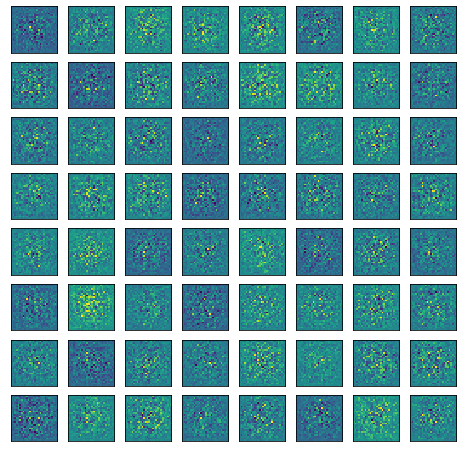

ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)

In [0]:
# Sanity check the generator
batch_size = 64
sample_noise = torch.randn(batch_size, 64)
gen_model = Generator(64)
with torch.no_grad():
    gen_sample_outputs = gen_model(sample_noise)
print(gen_sample_outputs.shape)

# visualize the outputs
display_grid(gen_sample_outputs)
next(iter(gen_model.children()))

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False)
        torch.nn.init.normal_(self.conv_1.weight, std=0.02)
        self.bn_1 = nn.BatchNorm2d(64)

        self.conv_2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False)
        torch.nn.init.normal_(self.conv_2.weight, std=0.02)
        self.bn_2 = nn.BatchNorm2d(128)

        self.conv_3 = nn.Conv2d(128, 1, 7, bias=False)

    def forward(self, input_batch):
        # Convert the input noise vector into a (10 x 10) tensor
        conv_1_out = self.conv_1(input_batch)
        # conv_1_out = F.leaky_relu(conv_1_out, negative_slope=0.2)
        conv_1_out = swish(conv_1_out)
        # conv_1_out = F.dropout(conv_1_out, p=0.5, training=True)

        # conv_2_out = F.leaky_relu(self.bn_2(self.conv_2(conv_1_out)), negative_slope=0.2)
        # conv_2_out = F.leaky_relu(self.conv_2(conv_1_out), negative_slope=0.2)
        conv_2_out = swish(self.conv_2(conv_1_out))
        conv_2_out = F.dropout(conv_2_out, p=0.3, training=True)

        # conv_3_out = F.leaky_relu(self.conv_3(conv_2_out))
        conv_3_out = swish(self.conv_3(conv_2_out))
        output = torch.sigmoid(conv_3_out)
        output = torch.reshape(output, (-1, 1))
        return output

    def selective_forward(self, name, input_batch):
        if name == 'conv_1':
            output = F.leaky_relu(self.conv_1(input_batch), negative_slope=0.2)
            return output
        elif name == 'conv_2':
            output = F.leaky_relu(self.conv_1(input_batch), negative_slope=0.2)
            output = F.leaky_relu(self.conv_2(output), negative_slope=0.2)
            output = F.dropout(output, p=0.3, training=True)
            return output
        else:
            raise ValueError('Invalid module name')

In [0]:
# sanity check the discriminator output
disc_model = Discriminator()
disc_sample_outputs = disc_model(gen_sample_outputs)
print(disc_sample_outputs.shape)

torch.Size([64, 1])


## Training schedule

In [0]:
num_epochs = 50
learning_rate = 0.0001
code_size = 64
log_step = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sample_noise = torch.randn(batch_size, code_size).to(device)  # This is used to visualize the samples generated over time
# k = 5  # Number of times to train the critic till optimality
k = 1
reg_param = 10
recon_loss_param = 0.1
c = 0.01  # This parameter is used for weight clipping (Used only for WGAN)

In [0]:
# Define the wasserstein loss here
def w_disc_loss(real_samples, noise_samples, disc_model, gen_model):
    real_output = disc_model(real_samples)
    fake_samples = gen_model(noise_samples)
    fake_output = disc_model(fake_samples)
    return -torch.mean(real_output - fake_output)

def w_disc_loss_gp(real_samples, noise_samples, epsilon, reg_param, disc_model, gen_model):
    real_output = disc_model(real_samples)
    fake_samples = gen_model(noise_samples)
    fake_output = disc_model(fake_samples)
    critic_loss = -torch.mean(real_output - fake_output)
    
    # Compute the gradient penalty
    aux_samples = epsilon * real_samples + (1 - epsilon) * fake_samples
    aux_outputs = disc_model(aux_samples)
    gradients = grad(outputs=aux_outputs,
                     inputs=aux_samples,
                     grad_outputs=torch.ones(aux_outputs.shape, device=device),
                     create_graph=True,
                     retain_graph=True)[0]
    gradient_penalty = reg_param * (torch.pow(torch.norm(gradients, 2), 2) - 1)
    return critic_loss + gradient_penalty

def w_gen_loss(noise_samples, disc_model, gen_model):
    fake_samples = gen_model(noise_samples)
    fake_output = disc_model(fake_samples)
    return -torch.mean(fake_output)

In [0]:
# Define the LSGAN Loss function here
def ls_disc_loss(real_samples, noise_samples, disc_model, gen_model):
    real_output = disc_model(real_samples)
    real_loss = torch.mean(torch.pow(real_output - 1, 2))

    fake_samples = gen_model(noise_samples)
    fake_output = disc_model(fake_samples)
    fake_loss = torch.mean(torch.pow(fake_output, 2))
    return real_loss + fake_loss

def ls_gen_loss(noise_samples, disc_model, gen_model):
    fake_samples = gen_model(noise_samples)
    fake_output = disc_model(fake_samples)
    return torch.mean(torch.pow(fake_output - 1, 2))

In [0]:
def reconstruction_loss(data_batch, noise_samples, disc_model, gen_model):
    real_activation = disc_model.selective_forward('conv_2', data_batch)
    fake_samples = gen_model(noise_samples)
    fake_activation = disc_model.selective_forward('conv_2', fake_samples)
    statistics_loss = nn.MSELoss()
    return statistics_loss(fake_activation, real_activation)

In [0]:
gen_model_name = '/content/drive/My Drive/gan_results/models/wgan_mnist_gen.pt'
disc_model_name = '/content/drive/My Drive/gan_results/models/wgan_mnist_disc.pt'
gen_model = Generator(code_size, training=True)
# gen_model.load_state_dict(torch.load(gen_model_name))
gen_loss = nn.BCELoss()
gen_model = gen_model.to(device)
gen_optim = torch.optim.Adam(gen_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# gen_optim = torch.optim.RMSprop(gen_model.parameters(), lr=learning_rate)

disc_model = Discriminator()
disc_loss = nn.BCELoss()
disc_model = disc_model.to(device)
# disc_model.load_state_dict(torch.load(disc_model_name))
disc_optim = torch.optim.Adam(disc_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# disc_optim = torch.optim.RMSprop(disc_model.parameters(), lr=learning_rate)

In [0]:
def train_one_epoch(disc_model, gen_model, disc_optim, gen_optim, loader, k, device, epoch_idx, log_step=50):
    disc_model.train()
    gen_model.train()
    gen_loss_profile = []
    disc_loss_profile = []
    for step_id, (data_batch, _) in enumerate(loader):
        # Move the data to the device
        data_batch = data_batch.to(device)
        for idx in range(k):
            noise_batch = torch.randn(batch_size, code_size).to(device)
            gen_output_batch = gen_model(noise_batch)
            fake_labels_batch = torch.zeros([batch_size, 1]).to(device)
            real_target_batch = torch.ones([batch_size, 1]).to(device)

            train_batch = torch.cat((gen_output_batch, data_batch), 0)
            train_labels = torch.cat((fake_labels_batch, real_target_batch), 0)

            # zero out any previous gradients
            disc_optim.zero_grad()

            # Train the discriminator
            preds = disc_model(train_batch)
            d_loss = disc_loss(preds, train_labels)
            # d_loss = w_disc_loss(data_batch, noise_batch, disc_model, gen_model)
            # d_loss = ls_disc_loss(data_batch, noise_batch, disc_model, gen_model)
            # epsilon = torch.randn(batch_size, 1, 1, 1).to(device)
            # d_loss = w_disc_loss_gp(data_batch, noise_batch, epsilon, reg_param, disc_model, gen_model)
            d_loss.backward()
            disc_optim.step()

            # # Clip the weights of the critic
            # for p in disc_model.parameters():
            #     p = torch.clamp(p, min=-c, max=c)

        # Train the Generator
        gen_optim.zero_grad()
        noise_batch = torch.randn(batch_size, code_size).to(device)
        gen_target_batch = torch.ones([batch_size, 1]).to(device)
        disc_preds = disc_model(gen_model(noise_batch))
        g_loss = gen_loss(disc_preds, gen_target_batch)
        # g_loss = w_gen_loss(noise_batch, disc_model, gen_model)
        # g_loss = ls_gen_loss(noise_batch, disc_model, gen_model)
        g_loss.backward()
        gen_optim.step()

        if step_id % log_step == 0:
            clear_output()
            print(f'Training for epoch: {epoch_idx + 1}')
            print(f"G-Loss: {g_loss.item()} D-Loss: {d_loss.item()}")
            # display the dummy sample
            with torch.no_grad():
                sample_gen_output = gen_model(sample_noise.cuda())
                display_grid(sample_gen_output)

        # Create loss profiles for further visualization
        gen_loss_profile.append(g_loss.item())
        disc_loss_profile.append(d_loss.item())
    return gen_loss_profile, disc_loss_profile

In [0]:
gen_loss_prof = []
disc_loss_prof = []
for epoch_idx in range(num_epochs):
    gen_loss_profile, disc_loss_profile = train_one_epoch(disc_model, gen_model,
                                                          disc_optim, gen_optim,
                                                          mnist_loader, k, device,
                                                          epoch_idx, log_step=log_step)
    gen_loss_prof.extend(gen_loss_profile)
    disc_loss_prof.extend(disc_loss_profile)

Training for epoch: 2
G-Loss: 0.6874987483024597 D-Loss: 0.697882354259491


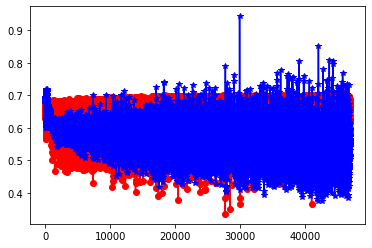

In [0]:
plt.plot(gen_loss_prof, color='red', marker='o')
plt.plot(disc_loss_prof, color='blue', marker='*')
plt.show()

## Model Evaluation

Save the model and write the samples to a new directory to calculate the FID score

In [0]:
disc_model_name = 'dcgan_mnist_disc.pt'
gen_model_name = 'dcgan_mnist_gen_swish.pt'

In [0]:
torch.save(gen_model.state_dict(), gen_model_name)
torch.save(disc_model.state_dict(), disc_model_name)

In [0]:
gen_model = Generator(code_size, training=True)
disc_model = Discriminator()

gen_model.load_state_dict(torch.load(gen_model_name))
disc_model.load_state_dict(torch.load(disc_model_name))

gen_model.to(device)
disc_model.to(device)

Discriminator(
  (conv_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
)

In [0]:
num_samples = 8192
noise_batch = torch.randn(num_samples, code_size).to(device)
gen_model.eval()
generated_samples = gen_model(noise_batch)

In [0]:
!rm -rf vanilla_samples/* mnist_samples/*
!mkdir -p vanilla_samples/ mnist_samples/

In [0]:
from PIL import Image

gen_samples = 'vanilla_samples'
mnist_samples = 'mnist_samples'
# Write the generated samples to the dir
for sample_idx in tqdm(range(num_samples)):
    with torch.no_grad():
        sample = torch.squeeze(generated_samples[sample_idx].permute(1, 2, 0).cpu()).numpy()
    sample_img = Image.fromarray((sample * 255).astype(np.uint8))
    sample_img.save(f'{gen_samples}/sample_{sample_idx}.png')

100%|██████████| 8192/8192 [00:02<00:00, 3133.91it/s]


In [0]:
# Write the MNIST samples. To be done only once
for sample_idx in tqdm(range(num_samples)):
    sample, target = mnist_dataset[sample_idx]
    sample = torch.squeeze(sample.permute(1, 2, 0)).numpy()
    sample_img = Image.fromarray((sample * 255).astype(np.uint8))
    sample_img.save(f'{mnist_samples}/sample_{sample_idx}.png')

100%|██████████| 8192/8192 [00:03<00:00, 2673.07it/s]


In [0]:
!pytorch-fid/fid_score.py /content/mnist_samples /content/vanilla_samples --gpu 0

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:03<00:00, 30.3MB/s]
100% 163/163 [00:19<00:00,  8.26it/s]
100% 163/163 [00:19<00:00,  8.30it/s]
FID:  128.31448136313156


In [0]:
# Copy the models to drive
!cp /content/{wgan_mnist_disc.pt,wgan_mnist_gen.pt,wgan_fmnist_disc.pt,wgan_fmnist_gen.pt,wgan_fmnist_disc_ft.pt,wgan_fmnist_gen_ft.pt} "/content/drive/My Drive/gan_results/models/"